# Speed measurement filter design

~~~c++
static uint32_t TachoLastTs[4] = { 0, 0, 0, 0 };	// Last timestamp in ms
static uint32_t TachoDT[4] = { 0, 0, 0, 0 }; 		// Deltatime with respect to last timestamp
static float AppliedThrottle[2] = { 0, 0 };			// Applied throttle

void HAL_GPIO_EXTI_Callback( uint16_t GPIO_Pin)
{
	uint32_t CurrTS = HAL_GetTick();
	switch(GPIO_Pin)
	{
		case TACHO1_Pin: { TachoDT[0] =  CurrTS - TachoLastTs[0]; TachoLastTs[0] = CurrTS; } break;
		case TACHO2_Pin: { TachoDT[1] =  CurrTS - TachoLastTs[1]; TachoLastTs[1] = CurrTS; } break;
		case TACHO3_Pin: { TachoDT[2] =  CurrTS - TachoLastTs[2]; TachoLastTs[2] = CurrTS; } break;
		case TACHO4_Pin: { TachoDT[3] =  CurrTS - TachoLastTs[3]; TachoLastTs[3] = CurrTS; } break;
		default: { __NOP(); }
	};
	//HAL_GPIO_TogglePin(LD2_GPIO_Port, LD2_Pin);
}
~~~

## 1. Load traces genereated using Intruction Trace Macrocell

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#CSV_TRACE_PATH = "../../SWV_export"
CSV_TRACE_PATH = "./"
!ls {CSV_TRACE_PATH}

A02_TachometerFilterDesign.ipynb  SWV_Data_Trace1.txt  Untitled.ipynb
SWV_Data_Trace0.txt		  SWV_Data_Trace2.txt


In [3]:
def load_swv_series(filename,name, variable_count):
    df = pd.read_csv(filename, skiprows=variable_count+2,sep=";", names=["Access","Value","PC","Cycles","Time"])
    df.Time = df.Time.apply(lambda x: float(x.replace("s","")) if x != "?" else np.nan)
    df["Variable"] = name    
    df.drop(['PC'], axis=1,inplace=True)        
    df.dropna(axis=0,inplace=True)
    df.index = df.Time
    df.drop(['Access', 'Time'], axis=1,inplace=True)
    return df

In [4]:
df_tacho0 = load_swv_series(os.path.join(CSV_TRACE_PATH,"SWV_Data_Trace0.txt"),"Tacho0",3)
df_tacho0.head()

,Value,Cycles,Variable
Time,,,
141.479386,27425,13582021075,Tacho0
141.530925,52,13586968819,Tacho0
141.575399,44,13591238324,Tacho0
141.587210,12,13592372171,Tacho0
141.615869,29,13595123397,Tacho0


In [5]:
df_tacho1 = load_swv_series(os.path.join(CSV_TRACE_PATH,"SWV_Data_Trace1.txt"),"Tacho1",3)
df_tacho1.head()

,Value,Cycles,Variable
Time,,,
17.091969,58055,1640829037,Tacho1
17.091981,0,1640830166,Tacho1
17.157836,66,1647152234,Tacho1
17.172507,14,1648560636,Tacho1
17.208317,36,1651998451,Tacho1


In [6]:
df_throttle = load_swv_series(os.path.join(CSV_TRACE_PATH,"SWV_Data_Trace2.txt"),"Throttle",3)
df_throttle.head()

,Value,Cycles,Variable
Time,,,
4.567082,0.000000,438439892,Throttle
5.569858,0.032258,534706377,Throttle
6.572565,0.064516,630966246,Throttle
7.575255,0.096774,727224443,Throttle
8.577901,0.129032,823478472,Throttle


In [7]:
df = pd.concat([df_tacho0,df_tacho1,df_throttle]).sort_values("Time")
df

,Value,Cycles,Variable
Time,,,
4.567082,0.000000,438439892,Throttle
5.569858,0.032258,534706377,Throttle
6.572565,0.064516,630966246,Throttle
7.575255,0.096774,727224443,Throttle
8.577901,0.129032,823478472,Throttle
...,...,...,...
191.392166,111.000000,18373647912,Tacho0
191.398901,0.193548,18374294522,Throttle
191.455693,64.000000,18379746530,Tacho0


/tmp/ipykernel_13932/2378248849.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[region_filter][df.Variable=="Throttle"].index,
/tmp/ipykernel_13932/2378248849.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[region_filter][df.Variable=="Throttle"].Value*100
/tmp/ipykernel_13932/2378248849.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[region_filter][df.Variable=="Tacho0"].index,
/tmp/ipykernel_13932/2378248849.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[region_filter][df.Variable=="Tacho0"].Value
/tmp/ipykernel_13932/2378248849.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[region_filter][df.Variable=="Tacho1"].index,
/tmp/ipykernel_13932/2378248849.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[region_filter][df.Variable=="Tacho1"].Value


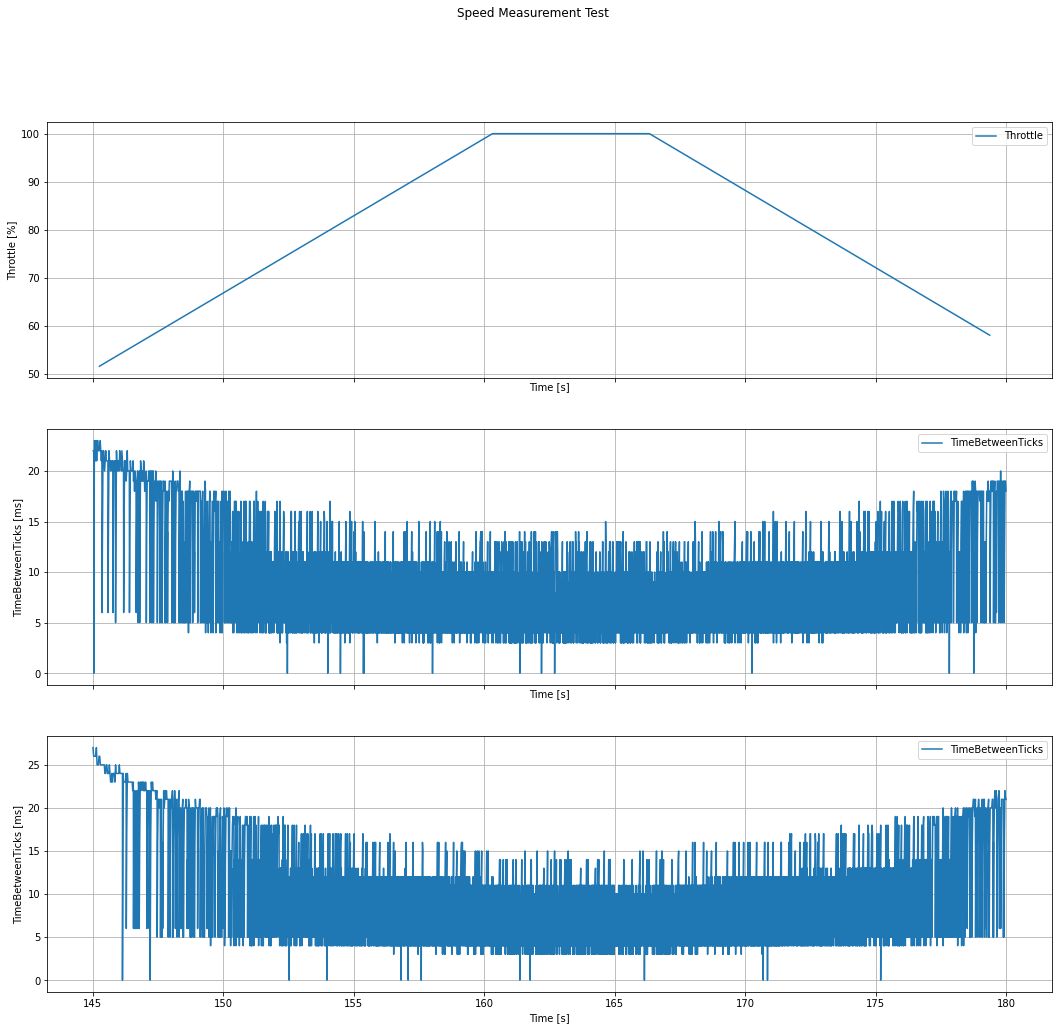

In [22]:
fig, axes = plt.subplots(3,1,figsize=(18,16),sharex=True)

region_filter = (df.index >= 145) & (df.index <= 180)

axes[0].plot(
    df[region_filter][df.Variable=="Throttle"].index,
    df[region_filter][df.Variable=="Throttle"].Value*100
)
axes[0].grid(which="Both")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Throttle [%]")
axes[0].legend(["Throttle"])

axes[1].plot(
    df[region_filter][df.Variable=="Tacho0"].index,
    df[region_filter][df.Variable=="Tacho0"].Value
)
axes[1].grid(which="Both")
axes[1].set_xlabel("Time [s]")
axes[1].set_ylabel("TimeBetweenTicks [ms]")
axes[1].legend(["TimeBetweenTicks"])

axes[2].plot(
    df[region_filter][df.Variable=="Tacho1"].index,
    df[region_filter][df.Variable=="Tacho1"].Value
)
axes[2].grid(which="Both")
axes[2].set_xlabel("Time [s]")
axes[2].set_ylabel("TimeBetweenTicks [ms]")
axes[2].legend(["TimeBetweenTicks"])

fig.suptitle("Speed Measurement Test");

/tmp/ipykernel_13932/913496314.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[region_filter][df.Variable=="Tacho0"].index,
/tmp/ipykernel_13932/913496314.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[region_filter][df.Variable=="Tacho0"].Value


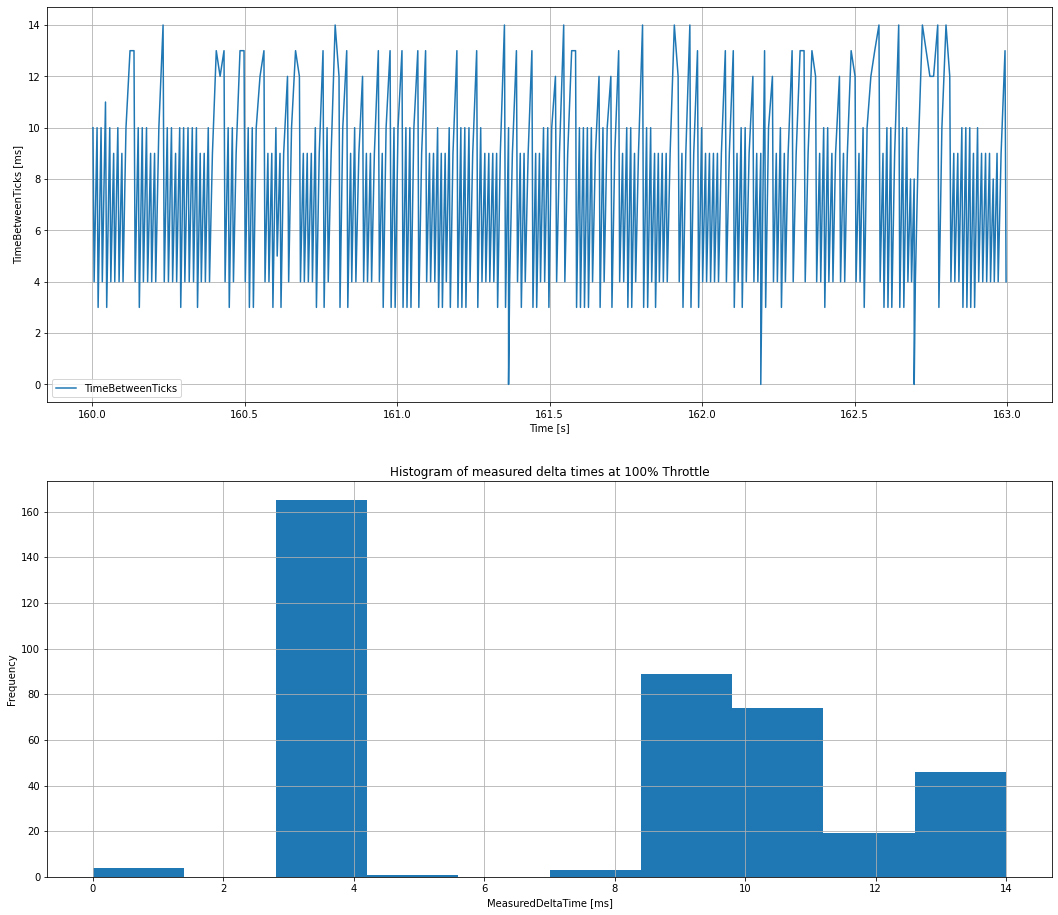

In [23]:
fig, axes = plt.subplots(2,1,figsize=(18,16))
region_filter = (df.index >= 160) & (df.index <= 163)

axes[0].plot(
    df[region_filter][df.Variable=="Tacho0"].index,
    df[region_filter][df.Variable=="Tacho0"].Value
)
axes[0].grid(which="Both")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("TimeBetweenTicks [ms]")
axes[0].legend(["TimeBetweenTicks"])

axes[1].hist(df[region_filter & (df.Variable=="Tacho0")].Value)
axes[1].set_xlabel("MeasuredDeltaTime [ms]")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Histogram of measured delta times at 100% Throttle")
axes[1].grid(which="Both")

## 2. Filter design

In [24]:
TPR = 20 # Ticks per revolution

In [25]:
def rpm2dt(rpm:float, tpr:int) -> float:
    """ Computes RPM, given the time between ticks.
    
        Parameters
        ----------
        rpm : float
            RPM.
        tpr: int
            Ticks per revolution.

        Raises
        ------
        ValueError
            If rpm is zero.
    """
    dt1rpm = (60*1000)/tpr
    if rpm is not None:
        return dt1rpm/rpm
    else:
        raise ValueError("RPM can't be zero")

def dt2rpm(dt:float, tpr:int) -> float:
    """ Computes the time between ticks, given RPM.
            
        Parameters
        ----------
        dt : float
            Delta time between ticks, in milliseconds.
        tpr: int
            Ticks per revolution.

        Raises
        ------
        ValueError
            If dt is zero.
    """
    dt1rpm = (60*1000)/tpr
    if dt is not None:
        return dt1rpm/dt
    else:
        raise ValueError("Deltatime can't be zero")
        
def irqs_per_second(rpm:float, tpr:int) -> float:
    """ Computes the generated IRQs per second, given RPM.
            
        Parameters
        ----------
        rpm : float
            RPM.
        tpr: int
            Ticks per revolution.

        Raises
        ------
        ValueError
            If dt is zero.
    """
    return 1000./rpm2dt(rpm,tpr)

In [26]:
from abc import ABC, abstractmethod

class Filter(ABC):
    @abstractmethod
    def reset(self):
        """ Sets filter to reset state.
        """
        assert(False)
    
    @abstractmethod    
    def process(self,sample:float) -> float:
        """ Receives a new sample and returns the filter output.
            
        Parameters
        ----------
        sample : float
            New sample.
        
        Returns
        -------
        result: float or None.
            Filter result (can be None if the filter is not ready yet).
        """
        assert(False)
    
class MovingAverageFilter(Filter):
    def __init__(self,n:int):
        self.n = n
        self.reset()
    
    def reset(self):
        self.sample_idx = 0
        self.buffer = [0.]*self.n
        self.enough_samples = False
    
    def process(self,sample:float) -> float:
        result = None
        self.buffer[self.sample_idx] = sample
        self.sample_idx+=1
        if self.sample_idx == self.n:
            self.enough_samples = True
            self.sample_idx = 0
        if self.enough_samples:
            result = 0
            for v in self.buffer:
                result+=v
            result/=self.n
        return result

/tmp/ipykernel_13932/1118921513.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[region_filter][df.Variable=="Tacho0"].index,
/tmp/ipykernel_13932/1118921513.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[region_filter][df.Variable=="Tacho0"].Value
/tmp/ipykernel_13932/1118921513.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[region_filter][df.Variable=="Tacho0"].index,
/tmp/ipykernel_13932/1118921513.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[region_filter][df.Variable=="Tacho0"].Filtered,
/tmp/ipykernel_13932/1118921513.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[region_filter][df.Variable=="Tacho0"].index,
/tmp/ipykernel_13932/1118921513.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[region_filter][df.Variable=="Tacho0"].Speed


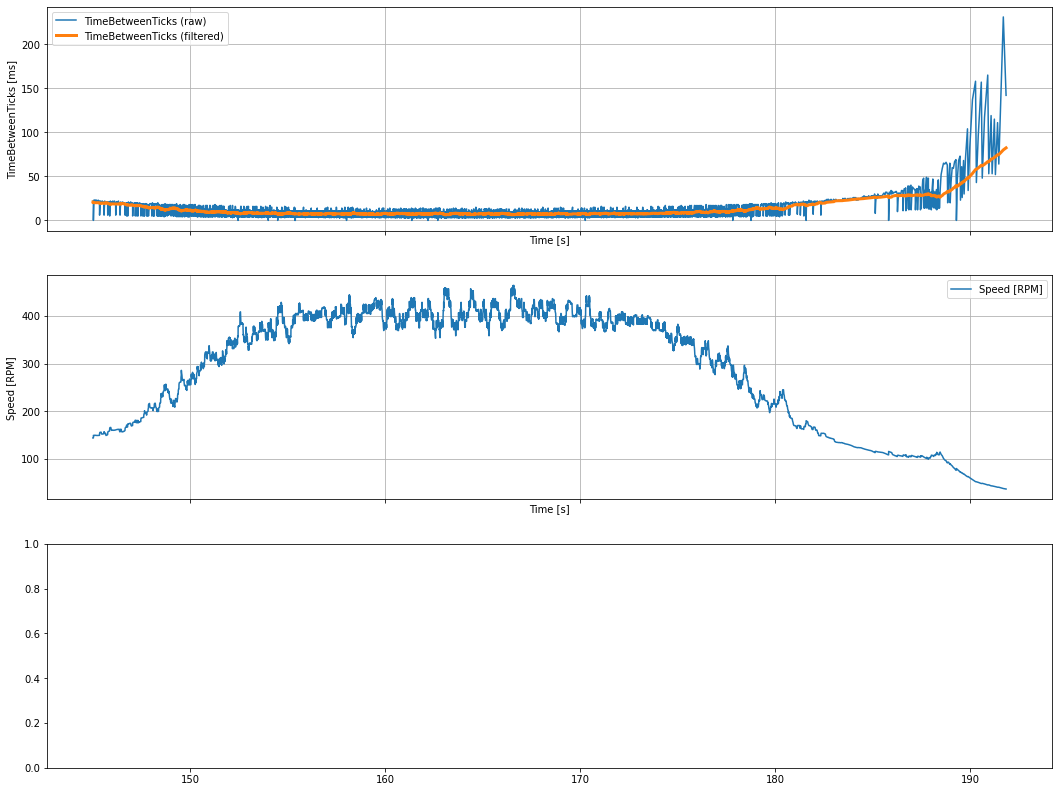

In [58]:
FILTER_SIZE = 32
f = MovingAverageFilter(FILTER_SIZE)
df.loc[df.Variable=="Tacho0","Filtered"]=df.loc[df.Variable=="Tacho0","Value"].apply(lambda x: f.process(x))
df.loc[df.Variable=="Tacho0","Speed"]=df.loc[df.Variable=="Tacho0","Filtered"].apply(lambda x: dt2rpm(x,TPR))

f = MovingAverageFilter(FILTER_SIZE)
df.loc[df.Variable=="Tacho1","Filtered"]=df.loc[df.Variable=="Tacho1","Value"].apply(lambda x: f.process(x))
df.loc[df.Variable=="Tacho1","Speed"]=df.loc[df.Variable=="Tacho1","Filtered"].apply(lambda x: dt2rpm(x,TPR))

fig, axes = plt.subplots(3,1,figsize=(18,14),sharex=True)
region_filter = (df.index >= 145) 

axes[0].plot(
    df[region_filter][df.Variable=="Tacho0"].index,
    df[region_filter][df.Variable=="Tacho0"].Value
)

axes[0].plot(
    df[region_filter][df.Variable=="Tacho0"].index,
    df[region_filter][df.Variable=="Tacho0"].Filtered,
    linewidth=3
)

axes[0].grid(which="Both")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("TimeBetweenTicks [ms]")
axes[0].legend(["TimeBetweenTicks (raw)","TimeBetweenTicks (filtered)"])

axes[1].plot(
    df[region_filter][df.Variable=="Tacho0"].index,
    df[region_filter][df.Variable=="Tacho0"].Speed
)

axes[1].grid(which="Both")
axes[1].set_xlabel("Time [s]")
axes[1].set_ylabel("Speed [RPM]")
axes[1].legend(["Speed [RPM]"])

